# Clustering assignment

####  Problem statement

HELP International is an international humanitarian NGO that is committed to fighting poverty and providing the people of backward countries with basic amenities and relief during the time of disasters and natural calamities. It runs a lot of operational projects from time to time along with advocacy drives to raise awareness as well as for funding purposes.

 
After the recent funding programmes, they have been able to raise around $ 10 million. Now the CEO of the NGO needs to decide how to use this money strategically and effectively. The significant issues that come while making this decision are mostly related to choosing the countries that are in the direst need of aid. 


#### business goal

We have to categorise the countries using some socio-economic and health factors that determine the overall development of the country. Then we need to suggest the countries which the CEO needs to focus on the most.

### Importing and Understanding Data

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# scale
from sklearn.preprocessing import StandardScaler

# KMeans Clustering
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import silhouette_score

# Hierarchial Clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree


## Reading the dataset

In [4]:
poverty = pd.read_csv("Country-data.csv")
print(poverty.shape)
poverty.head()

(167, 10)


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [5]:
poverty.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [6]:
poverty.dtypes

country        object
child_mort    float64
exports       float64
health        float64
imports       float64
income          int64
inflation     float64
life_expec    float64
total_fer     float64
gdpp            int64
dtype: object

In [7]:
poverty['exports'] = (poverty['exports']/100) * poverty['gdpp']
poverty['health'] = (poverty['health']/100) * poverty['gdpp']
poverty['imports'] = (poverty['imports']/100) * poverty['gdpp']
poverty.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


Now, we converted the features such as `exports`,`health`, `imports` from percentage form to the real value.

## EDA

In [8]:
col = poverty.columns
col = col[1:]
col

Index(['child_mort', 'exports', 'health', 'imports', 'income', 'inflation',
       'life_expec', 'total_fer', 'gdpp'],
      dtype='object')

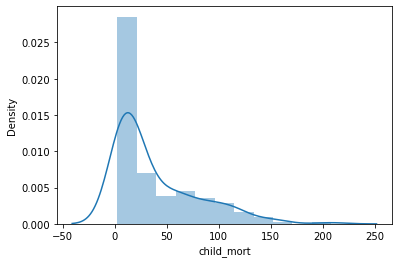

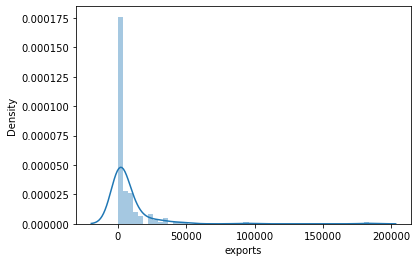

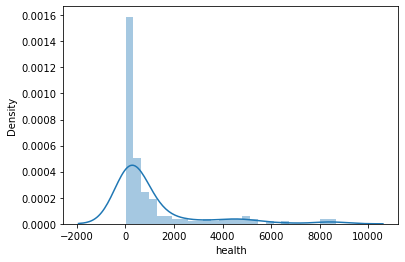

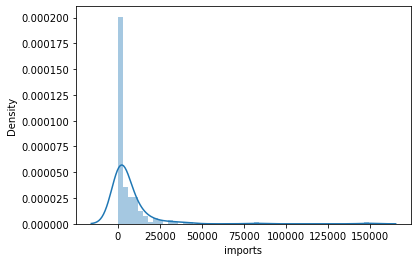

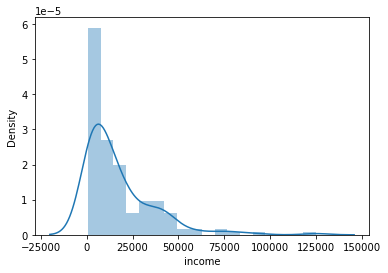

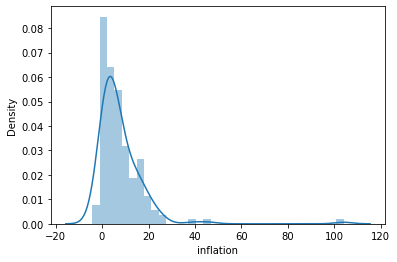

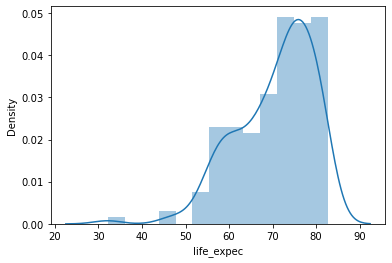

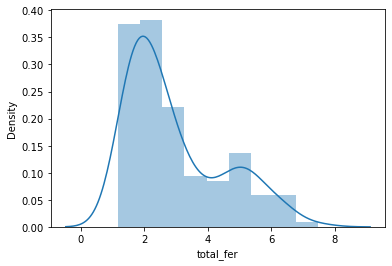

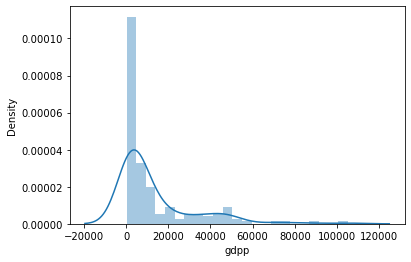

In [9]:
for i in col:
    sns.distplot(poverty[i])
    plt.show()

From the displot plotted above, we can say that variables such as exports, imports, inflation are have similar normal like distribution.

But for remaining features such as health, life_expec, child_mort, income, total_fer, gdpp, we can see that they are quite misbehaving from the normal distribution and needs to be grouped or binned as per the data's. Its implies that they are the indications of Cluster profiling.


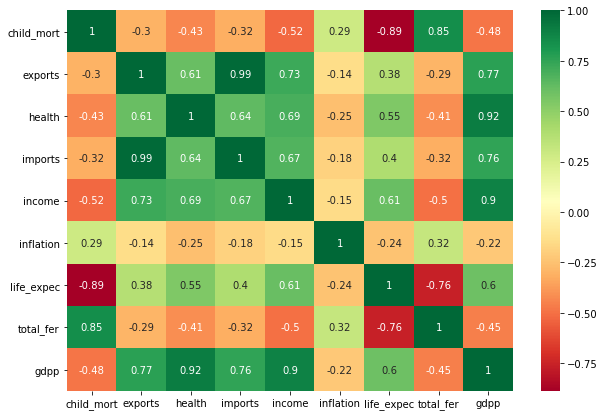

In [10]:
plt.figure(figsize=[10,7])
sns.heatmap(poverty[col].corr(),annot=True,cmap='RdYlGn')
plt.show()

###### But, as per our problem statement, we can only focus on features such as `child_mort`, `income`, `gdpp` for `clustering`.

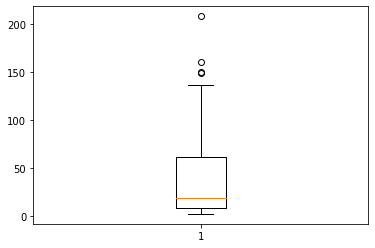

In [11]:
plt.boxplot(poverty['child_mort'])
plt.show()

Here, we have outliers for `child_mort`, but it highly affects our problem statement, if we remove these outliers. Because, our intuition is to find the countries, facing the poverty in dire.

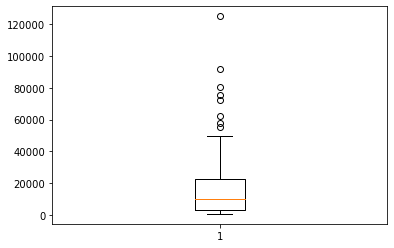

In [12]:
plt.boxplot(poverty['income'])
plt.show()

Here, we can see the outliers, and it affects our problem statement, if we are not remove these outliers. Because, we dont need to fund those countries who earns more than 50k per capita.

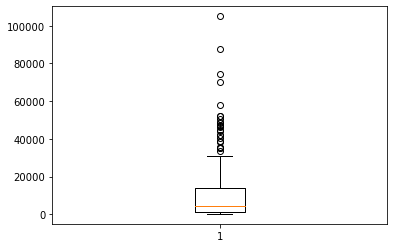

In [13]:
plt.boxplot(poverty['gdpp'])
plt.show()

Here also, we have outliers.But we should not remove it, because it might influence our performance of the model.So, we can cap it.

In [14]:
poverty['income'].quantile([0,0.25,0.5,0.75,0.90,0.95,0.96,0.97,0.98,0.99])

0.00      609.0
0.25     3355.0
0.50     9960.0
0.75    22800.0
0.90    41220.0
0.95    48290.0
0.96    56256.0
0.97    62496.0
0.98    74208.0
0.99    84374.0
Name: income, dtype: float64

In [15]:
Q = poverty['income'].quantile(0.95)
poverty = poverty[~(poverty['income']>Q)]
poverty.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


In [16]:
poverty['gdpp'].quantile([0,0.25,0.5,0.75,0.90,0.95,0.96,0.97,0.98,0.99])

0.00      231.0
0.25     1310.0
0.50     4480.0
0.75    12075.0
0.90    31670.0
0.95    44755.0
0.96    46704.0
0.97    47777.0
0.98    50076.0
0.99    51986.0
Name: gdpp, dtype: float64

In [17]:
Q1 = poverty['gdpp'].quantile(0.99)
poverty[poverty['gdpp']>Q1]['gdpp'] = Q1

Now, we have treated all our outliers of our requisite features. Its time to visualise ones again..

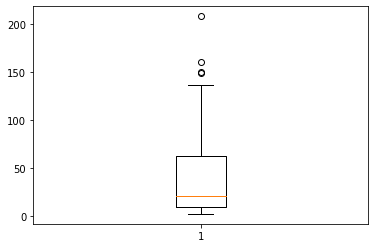

In [18]:
plt.boxplot(poverty['child_mort'])
plt.show()

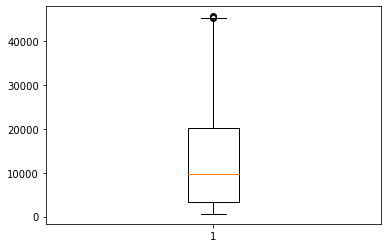

In [19]:
plt.boxplot(poverty['income'])
plt.show()

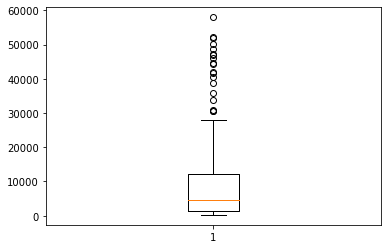

In [20]:
plt.boxplot(poverty['gdpp'])
plt.show()

Now, our dataset is pretty good for the modelling purpose.Lets move on..

## Check the cluster tendancy: Hopkin's Test

In [21]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [22]:
for i in range(15):
    print(hopkins(poverty[col]),end=' | ')

0.9188124196783447 | 0.9267540987296505 | 0.8848774377865901 | 0.8937469947895288 | 0.9084100607853691 | 0.9180952094994344 | 0.9293634960773977 | 0.9501294195910156 | 0.940663619369873 | 0.9354765319841973 | 0.9508735608190011 | 0.9175757009578229 | 0.8908810428808093 | 0.9469686178145758 | 0.9209903163411701 | 

Hopkin's test says that our data is around 90% different from the randomly scattered data.

The higher the value of dissimilarity, the more apt is our data for clustering.

## Scaling of dataset 

In [23]:
clust_df = poverty[['child_mort','income','gdpp']]
clust_df.head()

,child_mort,income,gdpp
0,90.2,1610,553
1,16.6,9930,4090
2,27.3,12900,4460
3,119.0,5900,3530
4,10.3,19100,12200


In [24]:
scaler = StandardScaler()
poverty_scaled = scaler.fit_transform(clust_df)

poverty_scaled = pd.DataFrame(poverty_scaled)
poverty_scaled.columns = 'Child_mort','Income','Gdpp'

poverty_scaled.head()

,Child_mort,Income,Gdpp
0,1.234828,-0.952872,-0.712215
1,-0.578249,-0.306993,-0.453112
2,-0.314663,-0.076432,-0.426007
3,1.944292,-0.619840,-0.494135
4,-0.733444,0.404872,0.140986


Now, we scaled our clustering features.

# KMeans clustering

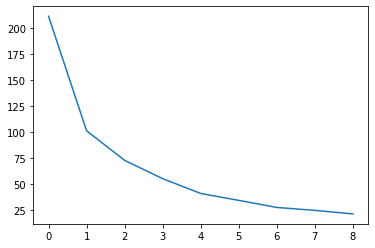

In [25]:
num = [2,3,4,5,6,7,8,9,10]
ssd = []
for i in num:
    k_means = KMeans(n_clusters=i,max_iter=50)
    k_means.fit(poverty_scaled)
    ssd.append(k_means.inertia_)
    
plt.plot(ssd)

From the above plot, it shows better perfoemance for K value as 4.

In [26]:
num = [2,3,4,5,6,7,8,9,10]

for i in num:
    k_means = KMeans(n_clusters=i,max_iter=50)
    k_means.fit(poverty_scaled)
    
    label = k_means.labels_
    silhouette = silhouette_score(poverty_scaled,label)
    print("for {0} clusters, the silhouette score is {1} ".format(i,silhouette))

for 2 clusters, the silhouette score is 0.5749918498494796 
for 3 clusters, the silhouette score is 0.5355715541230573 
for 4 clusters, the silhouette score is 0.46672544798769644 
for 5 clusters, the silhouette score is 0.45166409383664424 
for 6 clusters, the silhouette score is 0.46528166849665215 
for 7 clusters, the silhouette score is 0.463575658206908 
for 8 clusters, the silhouette score is 0.47177246138853585 
for 9 clusters, the silhouette score is 0.4834374130102515 
for 10 clusters, the silhouette score is 0.42959670138136763 


It also shows quite good to take k as 4

## Final KMeans with K = 4

In [27]:
kmeans = KMeans(n_clusters=4,random_state=0)
kmeans.fit(poverty_scaled)
poverty['labels'] = kmeans.labels_
poverty

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,labels
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,3
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,3
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,1
...,...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,1384.02,155.9250,1565.190,2950,2.62,63.0,3.50,2970,3
163,Venezuela,17.1,3847.50,662.8500,2376.000,16500,45.90,75.4,2.47,13500,1
164,Vietnam,23.3,943.20,89.6040,1050.620,4490,12.10,73.1,1.95,1310,3
165,Yemen,56.3,393.00,67.8580,450.640,4480,23.60,67.5,4.67,1310,3


In [28]:
poverty['labels'].value_counts()

3    66
1    37
0    32
2    23
Name: labels, dtype: int64

# Visualising the cluster using a Box plots

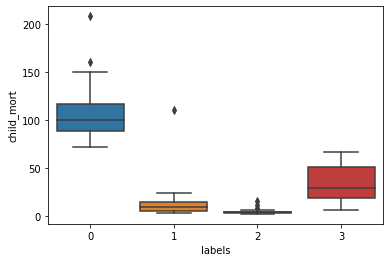

In [29]:
sns.boxplot(data = poverty,x='labels',y='child_mort')
plt.show()

From the above plot, we conclude that the cluster 0 countries are facing the poverty in its extreme, due to high death rate of below five aged children because of scarcity of food.


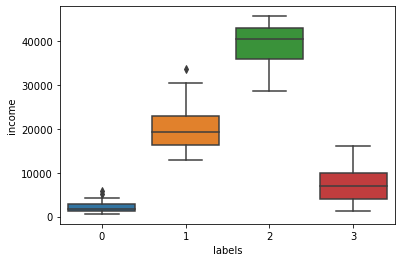

In [30]:
sns.boxplot(data = poverty,x='labels',y='income')
plt.show()

From the above plot, we can infer that the citizens of cluster 0 countries are earning the least as below 3000rs(approx) per month. And with help of that income, its very difficult to run their family. And countries under cluster 2 are average developing countries.

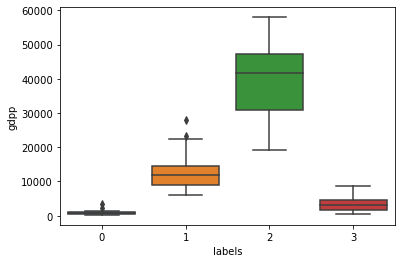

In [31]:
sns.boxplot(data = poverty,x='labels',y='gdpp')
plt.show()

From the above plot, we can say that countries in cluster 0 are the least `GDPP` rated ones. Also say that, they are facing the poverty the most.

# Visualising the cluster using a scatter plots

<AxesSubplot:xlabel='child_mort', ylabel='income'>

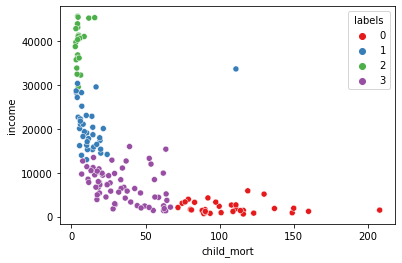

In [32]:
sns.scatterplot(x='child_mort', y='income', hue='labels', data=poverty, palette='Set1')

<AxesSubplot:xlabel='child_mort', ylabel='gdpp'>

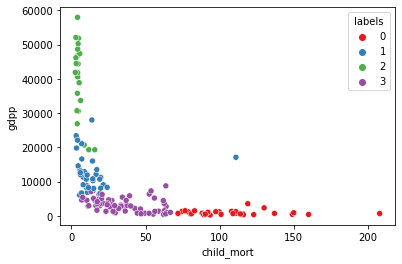

In [33]:
sns.scatterplot(x='child_mort', y='gdpp', hue='labels', data=poverty, palette='Set1')

<AxesSubplot:xlabel='gdpp', ylabel='income'>

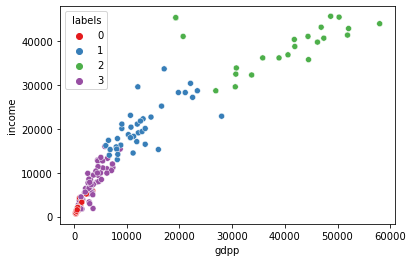

In [34]:
sns.scatterplot(x='gdpp', y='income', hue='labels', data=poverty, palette='Set1')

# Cluster Profiling:

__To make sense out of the cluster.__


We are required to find one such cluster that is having `LOW GDPP`, `LOW INCOME` and `HIGH CHILD_MORT`.

In [35]:
poverty[['child_mort','income','gdpp','labels']].groupby('labels').mean()

,child_mort,income,gdpp
labels,,,
0,107.496875,2114.468750,894.281250
1,13.702703,20524.324324,12807.837838
2,5.195652,39017.391304,39191.304348
3,34.321212,7110.606061,3327.378788


This we have already concluded to take cluster 0 as our target on the visualisation part itself.

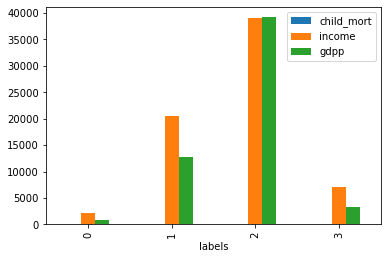

In [36]:
poverty[['child_mort','income','gdpp','labels']].groupby('labels').mean().plot(kind='bar');

## Identifying the countries 

In [37]:
Cluster_0 = poverty[poverty['labels']==0]
Cluster_0

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,labels
0,Afghanistan,90.2,55.3000,41.9174,248.297,1610,9.440,56.2,5.82,553,0
3,Angola,119.0,2199.1900,100.6050,1514.370,5900,22.400,60.1,6.16,3530,0
17,Benin,111.0,180.4040,31.0780,281.976,1820,0.885,61.8,5.36,758,0
25,Burkina Faso,116.0,110.4000,38.7550,170.200,1430,6.810,57.9,5.87,575,0
26,Burundi,93.6,20.6052,26.7960,90.552,764,12.300,57.7,6.26,231,0
28,Cameroon,108.0,290.8200,67.2030,353.700,2660,1.910,57.3,5.11,1310,0
31,Central African Republic,149.0,52.6280,17.7508,118.190,888,2.010,47.5,5.21,446,0
32,Chad,150.0,330.0960,40.6341,390.195,1930,6.390,56.5,6.59,897,0
36,Comoros,88.2,126.8850,34.6819,397.573,1410,3.870,65.9,4.75,769,0
37,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609,20.800,57.5,6.54,334,0


In [39]:
dire_countries_k = Cluster_0.sort_values(by = ['gdpp','income','child_mort'],ascending=[True,True,False],ignore_index=True)
dire_countries_k = pd.DataFrame(dire_countries_k['country'].head())
dire_countries_k

,country
0,Burundi
1,Liberia
2,"Congo, Dem. Rep."
3,Niger
4,Sierra Leone


##### These are the top 5 countries facing the poverty in its direst form

## Hierarchical clustering

In [40]:
poverty_scaled = poverty_scaled.iloc[:,:3]
poverty_scaled

,Child_mort,Income,Gdpp
0,1.234828,-0.952872,-0.712215
1,-0.578249,-0.306993,-0.453112
2,-0.314663,-0.076432,-0.426007
3,1.944292,-0.619840,-0.494135
4,-0.733444,0.404872,0.140986
...,...,...,...
153,-0.267858,-0.848848,-0.535157
154,-0.565931,0.203035,0.236218
155,-0.413200,-0.729298,-0.656761
156,0.399729,-0.730075,-0.656761


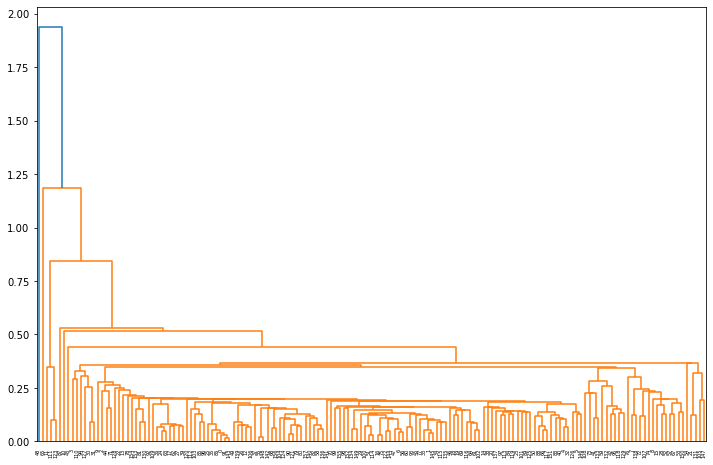

In [41]:
mergings = linkage(poverty_scaled,metric='euclidean',method='single')

plt.figure(figsize=[12,8])
dendrogram(mergings)
plt.xticks(rotation=90)
plt.show()

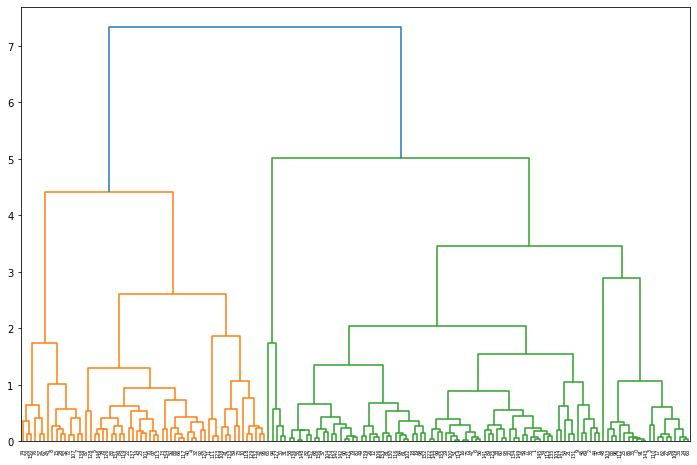

In [42]:
mergings = linkage(poverty_scaled,metric='euclidean',method='complete')

plt.figure(figsize=[12,8])
dendrogram(mergings)
plt.xticks(rotation=90)
plt.show()

In [43]:
poverty['label_id'] = cut_tree(mergings,n_clusters=4).reshape(-1)
poverty

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,labels,label_id
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,0,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,3,0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,3,0
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,0,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,1384.02,155.9250,1565.190,2950,2.62,63.0,3.50,2970,3,0
163,Venezuela,17.1,3847.50,662.8500,2376.000,16500,45.90,75.4,2.47,13500,1,1
164,Vietnam,23.3,943.20,89.6040,1050.620,4490,12.10,73.1,1.95,1310,3,0
165,Yemen,56.3,393.00,67.8580,450.640,4480,23.60,67.5,4.67,1310,3,0


In [44]:
poverty['label_id'].value_counts()

0    95
1    43
2    15
3     5
Name: label_id, dtype: int64

# Visualising the cluster using a Box plots

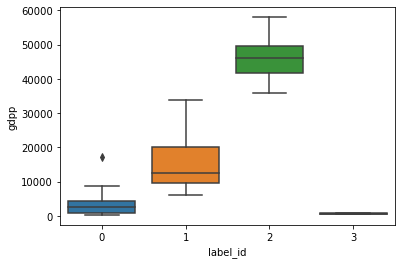

In [45]:
sns.boxplot(data = poverty,x='label_id',y='gdpp')
plt.show()

 From the above plot, we can say that countries in cluster 3 are the least GDPP rated ones. Also say that, they are facing the poverty the most.

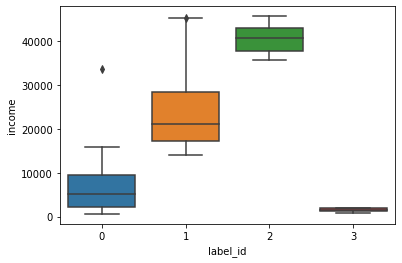

In [46]:
sns.boxplot(data = poverty,x='label_id',y='income')
plt.show()

From the above plot, we can infer that the citizens of cluster 3 countries are earning the least as below 2000rs(approx). And with help of that income, its very difficult to run their family.

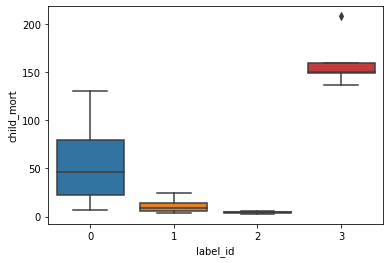

In [47]:
sns.boxplot(data = poverty,x='label_id',y='child_mort')
plt.show()

From the above plot, we conclude that the cluster 3 countries are facing the poverty in its extreme, due to high death rate of below five aged children because of scarcity of food.

#### From the above visualisation, we can infer that, cluster 3 is in very critical situation of poverty, so, they need the facilities to overcome from poverty.

# Visualising the cluster using a scatter plots

<AxesSubplot:xlabel='child_mort', ylabel='income'>

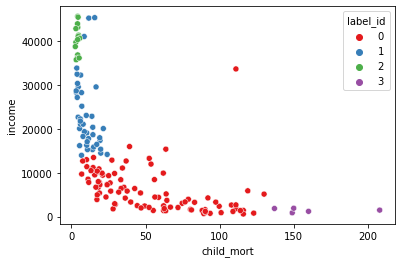

In [48]:
sns.scatterplot(x='child_mort', y='income', hue='label_id', data=poverty, palette='Set1')

<AxesSubplot:xlabel='gdpp', ylabel='income'>

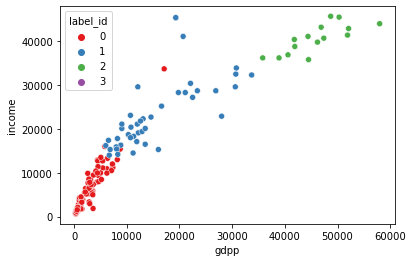

In [49]:
sns.scatterplot(x='gdpp', y='income', hue='label_id', data=poverty, palette='Set1')

<AxesSubplot:xlabel='child_mort', ylabel='gdpp'>

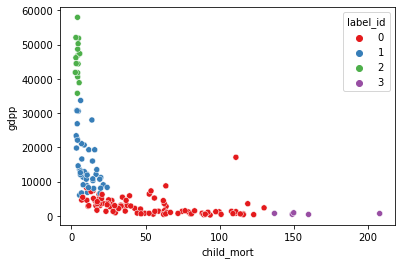

In [50]:
sns.scatterplot(x='child_mort', y='gdpp', hue='label_id', data=poverty, palette='Set1')

# Cluster Profiling:

__To make sense out of the cluster.__


We are required to find one such cluster that is having `LOW GDPP`, `LOW INCOME` and `HIGH CHILD_MORT`.

In [51]:
poverty[['child_mort','income','gdpp','label_id']].groupby('label_id').mean()

,child_mort,income,gdpp
label_id,,,
0,52.866316,6065.842105,2846.442105
1,10.323256,23290.697674,15362.558140
2,4.093333,40573.333333,45960.000000
3,160.800000,1481.600000,622.400000


<AxesSubplot:xlabel='label_id'>

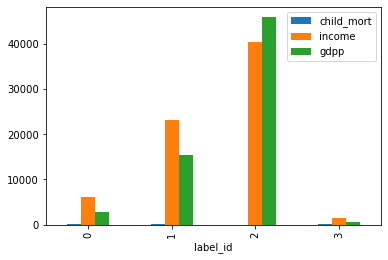

In [52]:
poverty[['child_mort','income','gdpp','label_id']].groupby('label_id').mean().plot(kind = 'bar')

## Identifying the countries 

In [53]:
Cluster_3 = poverty[poverty['label_id']==3]
Cluster_3

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,labels,label_id
31,Central African Republic,149.0,52.628,17.7508,118.190,888,2.01,47.5,5.21,446,0,3
32,Chad,150.0,330.096,40.6341,390.195,1930,6.39,56.5,6.59,897,0,3
66,Haiti,208.0,101.286,45.7442,428.314,1500,5.45,32.1,3.33,662,0,3
97,Mali,137.0,161.424,35.2584,248.508,1870,4.37,59.5,6.55,708,0,3
132,Sierra Leone,160.0,67.032,52.2690,137.655,1220,17.20,55.0,5.20,399,0,3


In [54]:
dire_countries_h = Cluster_3.sort_values(by = ['gdpp','income','child_mort'],ascending=[True,True,False],ignore_index=True)
dire_countries_h = pd.DataFrame(dire_countries_h['country'])
dire_countries_h.head()

,country
0,Sierra Leone
1,Central African Republic
2,Haiti
3,Mali
4,Chad


##### These are the top 5 countries facing the poverty in its direst form